## Finance Data Pipeline

#### Lendo o arquivo IBOV_index.csv, para pegar a lista de tickers da bolsa de valores, baseado no IBOV.

Importando as bibliotecas

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("IBOV_index.csv", sep=";", index_col=False)

In [ ]:
ticker_br = list(df["Codigo"])
print(ticker_br)

Verificando os ticker similares, tais como BBDC3 e BBDC4.

In [ ]:
ticker_dict = {}

for ticker in ticker_br:
    base = ticker[:4]
    number = int(ticker[4:])

    if base not in ticker_dict:
        ticker_dict[base] = [number]
    else:
        ticker_dict[base].append(number)

filtered_tickers = []

for base, numbers in ticker_dict.items():
    numbers.sort()

    if 11 in numbers:
        filtered_tickers.append(base + "11")
    elif 4 in numbers:
        filtered_tickers.append(base + "4")
    elif 3 in numbers:
        filtered_tickers.append(base + "3")

print("Tickers filtrados:", filtered_tickers)

#### Realizando o download dos arquivos xlsx brutos das empresas.

Importando as bibliotecas.

In [33]:
import time
import zipfile
from pathlib import Path
import os

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
from webdriver_manager.microsoft import EdgeChromiumDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [34]:
raw_path = str(Path(os.getcwd()).parent / "data" / "raw")
download_path = str(Path.home() / "Downloads")
print(download_path)
print(raw_path)

C:\Users\ernan\Downloads
c:\Users\ernan\Documents\myProjects\finance-data-pipeline\data\raw


Criando o driver do selenium

In [14]:
service = Service(EdgeChromiumDriverManager().install())
driver = webdriver.Edge(service=service)

Renomeando os arquivos

In [16]:
def rename_file(path, new_name_file):
    try:
        file_path = os.path.join(path, "balanco.xls")
        new_file_path = os.path.join(path, new_name_file)

        if os.path.exists(file_path):
            os.rename(file_path, new_file_path)
            print(f"Arquivo renomeado para {new_name_file}")
        else:
            print("Arquivo 'balanco.xls' não encontrado.")
    except Exception as e:
        print(f"Ocorreu um erro ao renomear o arquivo: {e}")

Extraindo os arquivos

In [17]:
def unzip_file(downloads_path, target_path):
    try:
        files = os.listdir(downloads_path)
        for file in files:
            if file.startswith("bal_") and file.endswith(".zip"):
                file_path = os.path.join(downloads_path, file)
                with zipfile.ZipFile(file_path, "r") as zip_ref:
                    zip_ref.extractall(target_path)
                os.remove(file_path)
                print(f"{file} extraido com sucesso!")
    except FileNotFoundError as e:
        print(f"Erro: Arquivo ou diretório não encontrado - {e}")
    except zipfile.BadZipFile as e:
        print(f"Erro: Arquivo ZIP corrompido - {e}")
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")

Realizando a extração no site fundamentus

In [36]:
def extraction_balance(ticket_list):
    print("Iniciando o processo de web scraping...")
    for ticket in ticket_list:
        print(f"Processando ticket: {ticket}")
        driver.get(
            f"https://www.fundamentus.com.br/balancos.php?papel={ticket}&interface=mobile#"
        )
        time.sleep(3)
        # driver.maximize_window()
        try:
            # Esperar pelo botão de download
            download_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.CLASS_NAME, "bt-baixar"))
            )
            time.sleep(1)
            download_button.click()
            time.sleep(5)  # Ajustar conforme necessário
            unzip_file(downloads_path=download_path, target_path=raw_path)
            time.sleep(3)
            new_name = f"bal_{ticket}.xls"
            rename_file(path=raw_path, new_name_file=new_name)
        except Exception as e:
            print(f"Erro ao processar o ticket {ticket}: {e}")
    print("Fim do processo de web scraping...")

In [ ]:
try:
    extraction_balance(sorted(filtered_tickers))
finally:
    driver.quit()

#### Pegando as cotações

In [35]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from openpyxl.workbook import Workbook
from pathlib import Path

In [36]:
def is_valid_file(file_path, column_threshold=40):
    """
    Verifica se um arquivo Excel é válido com base no número de colunas.

    Args:
        file_path (str): Caminho do arquivo a ser verificado.
        column_threshold (int): Número mínimo de colunas para o arquivo ser válido.

    Returns:
        bool: True se o arquivo for válido, False caso contrário.
    """
    df = pd.read_excel(file_path)
    return df.shape[1] > column_threshold

In [37]:
def check_balance(directory_path, column_threshold=40, delete_invalid=False):
    """
    Analisa arquivos Excel no diretório especificado, verificando sua validade.

    Args:
        directory_path (str): Caminho do diretório contendo os arquivos.
        column_threshold (int): Número mínimo de colunas para um arquivo ser considerado válido.
        delete_invalid (bool): Se True, arquivos inválidos serão excluídos.

    Returns:
        tuple: Lista de arquivos válidos e inválidos.
    """
    valid_files = []
    invalid_files = []

    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)

        if file_name.endswith(".xls") and os.path.isfile(file_path):
            if is_valid_file(file_path, column_threshold):
                valid_files.append(file_name)
            else:
                invalid_files.append(file_name)
                if delete_invalid:
                    os.remove(file_path)

    return valid_files, invalid_files

In [31]:
def get_company_tickers(path):
    print("Pegando os tickers das empresas validadas.")
    ticket_default, _ = check_balance(
        directory_path=path, column_threshold=1, delete_invalid=False
    )
    company_tickets = [
        ticket.replace("bal_", "").replace(".xls", ".SA") for ticket in ticket_default
    ]
    return company_tickets

In [32]:
def stock_price_retriver(tickers, start_date, end_date, output_file):
    print("Pegando as cotações das empresas.")
    """
    Baixa cotações de ações de uma lista de tickers usando yfinance e salva em um arquivo Excel.

    Args:
        tickers (list): Lista de tickers (códigos das empresas).
        start_date (str): Data de início no formato 'YYYY-MM-DD'.
        end_date (str): Data de fim no formato 'YYYY-MM-DD'.
        output_file (str): Nome do arquivo Excel para salvar os dados.
    """
    all_data = []

    for ticker in tickers:
        print(f"Baixando dados de {ticker}...")
        try:
            # Baixa os dados da ação no período especificado
            df = yf.download(ticker, start=start_date, end=end_date)

            if not df.empty:
                # Adiciona o nome do ticker em uma coluna para identificação
                df["Ticker"] = ticker
                # Remove MultiIndex completamente
                df = df.reset_index()
                df.columns = [
                    col if isinstance(col, str) else col[0] for col in df.columns
                ]
                all_data.append(df)
            else:
                print(f"Dados indisponíveis para {ticker}.")
        except Exception as e:
            print(f"Erro ao processar {ticker}: {e}")

    if all_data:
        # Concatena todos os DataFrames
        result = pd.concat(all_data, ignore_index=True)
        # Exporta para Excel
        result.to_excel(output_file, index=False, engine="openpyxl")
        print(f"Dados exportados com sucesso para {output_file}.")
    else:
        print("Nenhum dado foi exportado, pois não foram encontrados dados válidos.")

In [33]:
START_DAY = "2000-01-01"
END_DAY = datetime.today().strftime("%Y-%m-%d")

In [ ]:
company_tickers = get_company_tickers(raw_path)
company_tickers.append("^BVSP")
file_output = rf"{raw_path}\quotations.xlsx"
stock_price_retriver(company_tickers, START_DAY, END_DAY, file_output)

#### Processando os Balanços e DRE das empresas e Cotações

In [38]:
import numpy as np
import pandas as pd
import os

Verificando se as empresas tem pelo menos  4 trimestres de balanço

In [39]:
valid_files, invalid_files = check_balance(
    directory_path=raw_path,
    column_threshold=4,
    delete_invalid=False,
)

In [40]:
print(valid_files)
print(invalid_files)

['bal_ABEV3.xls', 'bal_ALOS3.xls', 'bal_ALPA4.xls', 'bal_ASAI3.xls', 'bal_AURE3.xls', 'bal_AZUL4.xls', 'bal_AZZA3.xls', 'bal_B3SA3.xls', 'bal_BBAS3.xls', 'bal_BBDC4.xls', 'bal_BBSE3.xls', 'bal_BEEF3.xls', 'bal_BPAC11.xls', 'bal_BRAP4.xls', 'bal_BRAV3.xls', 'bal_BRFS3.xls', 'bal_CCRO3.xls', 'bal_CMIG4.xls', 'bal_CMIN3.xls', 'bal_COGN3.xls', 'bal_CPFE3.xls', 'bal_CRFB3.xls', 'bal_CSAN3.xls', 'bal_CSNA3.xls', 'bal_CVCB3.xls', 'bal_CXSE3.xls', 'bal_CYRE3.xls', 'bal_EGIE3.xls', 'bal_ELET3.xls', 'bal_EMBR3.xls', 'bal_ENEV3.xls', 'bal_ENGI11.xls', 'bal_EQTL3.xls', 'bal_EZTC3.xls', 'bal_FLRY3.xls', 'bal_GGBR4.xls', 'bal_GOAU4.xls', 'bal_HAPV3.xls', 'bal_HYPE3.xls', 'bal_IGTI11.xls', 'bal_ISAE4.xls', 'bal_ITSA4.xls', 'bal_ITUB4.xls', 'bal_JBSS3.xls', 'bal_KLBN11.xls', 'bal_LREN3.xls', 'bal_LWSA3.xls', 'bal_MGLU3.xls', 'bal_MRFG3.xls', 'bal_MRVE3.xls', 'bal_MULT3.xls', 'bal_NTCO3.xls', 'bal_PCAR3.xls', 'bal_PETR4.xls', 'bal_PETZ3.xls', 'bal_PRIO3.xls', 'bal_RADL3.xls', 'bal_RAIL3.xls', 'bal_RAIZ

Junto o Balanço com o DRE para cada empresa

In [41]:
fundamentals = {}

for file in valid_files:
    ticket = file.replace("bal_", "").replace(".xls", "")
    print(ticket)

    balance = pd.read_excel(f"{raw_path}/{file}", sheet_name=0)
    balance.iloc[0, 0] = ticket
    balance.columns = balance.iloc[0]
    balance = balance[1:]

    dre = pd.read_excel(f"{raw_path}/{file}", sheet_name=1)
    dre.iloc[0, 0] = ticket
    dre.columns = dre.iloc[0]
    dre = dre[1:]

    combined = pd.concat([balance.set_index(ticket), dre.set_index(ticket)])
    fundamentals[ticket] = combined
    


ABEV3
ALOS3
ALPA4
ASAI3
AURE3
AZUL4
AZZA3
B3SA3
BBAS3
BBDC4
BBSE3
BEEF3
BPAC11
BRAP4
BRAV3
BRFS3
CCRO3
CMIG4
CMIN3
COGN3
CPFE3
CRFB3
CSAN3
CSNA3
CVCB3
CXSE3
CYRE3
EGIE3
ELET3
EMBR3
ENEV3
ENGI11
EQTL3
EZTC3
FLRY3
GGBR4
GOAU4
HAPV3
HYPE3
IGTI11
ISAE4
ITSA4
ITUB4
JBSS3
KLBN11
LREN3
LWSA3
MGLU3
MRFG3
MRVE3
MULT3
NTCO3
PCAR3
PETR4
PETZ3
PRIO3
RADL3
RAIL3
RAIZ4
RDOR3
RECV3
RENT3
SANB11
SBSP3
SLCE3
SMTO3
STBP3
SUZB3
TAEE11
TIMS3
TOTS3
UGPA3
VALE3
VAMO3
VBBR3
VIVA3
VIVT3
WEGE3
YDUQ3


In [42]:
fundamentals['B3SA3']

,31/12/2009,31/03/2010,30/06/2010,30/09/2010,31/12/2010,31/03/2011,30/06/2011,30/09/2011,31/12/2011,31/03/2012,...,30/06/2022,30/09/2022,31/12/2022,31/03/2023,30/06/2023,30/09/2023,31/12/2023,31/03/2024,30/06/2024,30/09/2024
B3SA3,,,,,,,,,,,,,,,,,,,,,
Ativo Total,21201184.768,21615536.128,21304356.864,22771748.864,22633975.808,24032278.528,22563971.072,23144968.192,23589922.816,23397232.64,...,47394320.384,48771391.488,47594770.432,45806399.488,47176957.952,47872684.032,49421623.296,48283271.168,46444945.408,46068084.736
Ativo Circulante,2778968.064,4192899.072,3786267.904,3131595.008,2547589.12,3779795.968,2209697.024,2198366.976,2401134.08,2806678.016,...,16721852.416,18498359.296,17129612.288,15579206.656,16141927.424,17212887.04,18843820.032,18439217.152,16781628.416,16434206.72
Caixa e Equivalentes de Caixa,2650563.072,4038099.968,3619712,2960681.984,104017,1542301.056,25097,139476.992,64648,34329,...,2371543.04,4267671.04,2613794.048,1929953.024,2170661.888,3174522.88,1788905.984,1664173.952,2366920.96,1901718.016
Aplicações Financeiras,0,0,0,0,2264408.064,2031428.992,1980413.952,1861837.056,2128705.024,2533289.984,...,12803062.784,12481081.344,12290716.672,12239222.784,12092050.432,11756456.96,14199566.336,15298609.152,12780746.752,12971382.784
Contas a Receber,97036,129052,140072,142880.992,51399,67326,71374,65440,46514,52228,...,431342.016,452375.008,503840,464980,504895.008,475030.016,566044.992,522838.016,553150.016,506967.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IR Diferido,-116961.016,-108310,-101836,-125761,-106713.992,-111167,-98627,-142179.008,-138286,-140098,...,-30583,77418,36949.992,-41253,-27164,-60232,70541,26249,68957,-114345
Participações/Contribuições Estatutárias,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reversão dos Juros sobre Capital Próprio,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Carregando as cotações

In [43]:
quote_df = pd.read_excel(f"{raw_path}/quotations.xlsx")
quote_df["Ticker"] = quote_df["Ticker"].str.replace(".SA", "", regex=False)
quote = {}
for ticker in quote_df["Ticker"].unique():
    quote[ticker] = quote_df.loc[quote_df["Ticker"] == ticker, :]

In [44]:
quote['ABEV3']

,Date,Adj Close,Close,High,Low,Open,Volume,Ticker
0,2000-01-05,0.294986,0.520882,0.520882,0.520882,0.520882,985,ABEV3
1,2000-01-06,0.280033,0.494478,0.494478,0.494478,0.494478,227,ABEV3
2,2000-01-07,0.280033,0.494478,0.494478,0.494478,0.494478,151,ABEV3
3,2000-01-10,0.280033,0.494478,0.494478,0.494478,0.494478,1516,ABEV3
4,2000-01-11,0.280033,0.494478,0.494478,0.494478,0.494478,3791,ABEV3
...,...,...,...,...,...,...,...,...
6262,2024-12-10,14.270000,14.270000,14.500000,14.270000,14.330000,22942500,ABEV3
6263,2024-12-11,13.800000,13.800000,14.360000,13.660000,14.270000,49150600,ABEV3
6264,2024-12-12,13.100000,13.100000,13.580000,13.100000,13.500000,49616900,ABEV3
6265,2024-12-13,13.080000,13.080000,13.360000,13.010000,13.100000,30867900,ABEV3


In [45]:
len(fundamentals)

79

In [46]:
fundamentals2 = fundamentals.copy()

Verificando se existe alguma empresa em nossa lista sem cotação, caso não tenha é removida das cotações e dos fundamentos.

In [47]:
for ticker in valid_files:
    ticker = ticker.replace("bal_", "").replace(".xls", "")
    if quote[ticker].isnull().values.any():
        quote.pop(ticker)
        fundamentals.pop(ticker)

In [48]:
len(fundamentals)

79

Juntando as cotações aos fundamentos.

In [49]:
for company in fundamentals:
    table = fundamentals[company].T
    table.index = pd.to_datetime(table.index, format="%d/%m/%Y")
    table_quote = quote[company].set_index("Date")
    table_quote = table_quote[["Adj Close"]]
    table = table.merge(table_quote, right_index=True, left_index=True)
    table.index.name = company
    fundamentals[company] = table

In [50]:
fundamentals['ABEV3']

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber,Estoques,Ativos Biológicos,Tributos a Recuperar,Despesas Antecipadas,Outros Ativos Circulantes,...,Receitas,Despesas,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Participações/Contribuições Estatutárias,Reversão dos Juros sobre Capital Próprio,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Adj Close
ABEV3,,,,,,,,,,,,,,,,,,,,,
2013-09-30,59618975.744,12478373.888,4835169.792,612489.024,2747849.984,2586540.032,0,850673.984,593452.992,252198,...,NaN,NaN,3171468.032,-370166.016,-462300,NaN,NaN,-49296,2289705.984,11.119470
2014-03-31,63297044.48,16352306.176,7296176.128,410172.992,3110085.12,3062296.064,0,1420519.936,682211.968,370844,...,NaN,NaN,3148656.896,-955091.968,403236,NaN,NaN,-50162,2546639.104,11.194549
2014-06-30,62989045.76,15773268.992,6273862.144,379937.984,3538383.872,3120457.984,0,1510418.944,553011.968,397196,...,NaN,NaN,2471577.088,-286887.008,30916,NaN,NaN,-48724,2166882.048,10.446081
2014-09-30,65125920.768,15446576.128,5748115.968,526788.992,3275641.088,3158974.976,0,1706011.008,539432,491612,...,NaN,NaN,3272332.032,-857676.032,475888,NaN,NaN,-76946,2813597.952,10.737000
2015-03-31,75101184,19241015.296,6974584.832,1033758.016,2897700.096,4377888.768,0,1394295.04,701361.984,1861427.968,...,NaN,NaN,3914327.04,-923454.976,-28029,NaN,NaN,-152180,2810662.912,13.492867
2015-06-30,74436157.44,18360256.512,6899779.072,776569.024,2850364.928,4078682.112,0,1436562.944,630521.984,1687776,...,NaN,NaN,2760078.08,-380468.992,211232,NaN,NaN,-82185,2508656.128,13.940182
2015-09-30,88043175.936,23835351.04,9680857.088,718737.024,3547086.08,4521418.24,0,1290409.984,825520,3251324.928,...,NaN,NaN,3901640.96,-525990.016,-308710.016,NaN,NaN,-116209,2950732.032,14.365723
2016-03-31,80248012.8,19074488.32,6007322.112,209067.008,3146114.048,4896058.88,0,3179339.008,748560,888025.984,...,NaN,NaN,3230375.936,-638854.016,302471.008,NaN,NaN,-127128,2766864.896,14.122336
2016-06-30,76656713.728,18561515.52,5729654.784,263892.992,3445761.024,4403950.08,0,3232646.912,703987.008,781624,...,NaN,NaN,2399104,-533547.008,306964,NaN,NaN,-126367,2046153.984,14.310134


Removendo da analise empresas que tem colunas diferentes.

In [51]:
cols = list(fundamentals["ABEV3"].columns)
companies = list(fundamentals.keys())
print(len(fundamentals))

for company in companies:
    if set(cols) != set(fundamentals[company].columns):
        fundamentals.pop(company)

print(len(fundamentals))

79
74


Verifica o nome das colunas, e colunas repitidas tem alterações no nome onde é incrementado _1 ao final

In [52]:
text_cols = ";".join(cols)

modified_cols = []

for col in cols:
    if cols.count(col) == 2 and col not in modified_cols:
        text_cols = text_cols.replace(f";{col};", f";{col}_1;", 1)
        modified_cols.append(col)

cols = text_cols.split(";")
print(cols)

['Ativo Total', 'Ativo Circulante', 'Caixa e Equivalentes de Caixa', 'Aplicações Financeiras', 'Contas a Receber_1', 'Estoques_1', 'Ativos Biológicos_1', 'Tributos a Recuperar', 'Despesas Antecipadas_1', 'Outros Ativos Circulantes', 'Ativo Realizável a Longo Prazo', 'Aplicações Financeiras Avaliadas a Valor Justo', 'Aplicações Financeiras Avaliadas ao Custo Amortizado', 'Contas a Receber', 'Estoques', 'Ativos Biológicos', 'Tributos Diferidos_1', 'Despesas Antecipadas', 'Créditos com Partes Relacionadas', 'Outros Ativos Não Circulantes', 'Investimentos', 'Imobilizado', 'Intangível', 'Diferido', 'Passivo Total', 'Passivo Circulante', 'Obrigações Sociais e Trabalhistas', 'Fornecedores', 'Obrigações Fiscais', 'Empréstimos e Financiamentos_1', 'Passivos com Partes Relacionadas_1', 'Dividendos e JCP a Pagar', 'Outros_1', 'Provisões_1', 'Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1', 'Passivo Não Circulante', 'Empréstimos e Financiamentos', 'Passivos com Partes Relacionadas'

Aplica os novos nomes das colunas

In [53]:
for company in fundamentals:
    fundamentals[company].columns = cols

Verifica se tem valores vazio em cada uma das colunas e suas quantidades

In [54]:
empty_values = dict.fromkeys(cols, 0)
total_row = 0
for company in fundamentals:
    table = fundamentals[company]
    total_row += table.shape[0]
    for col in cols:
        quantity_empty_values = pd.isnull(table[col].sum())
        empty_values[col] += quantity_empty_values

In [55]:
print(quantity_empty_values)
print(empty_values)

False
{'Ativo Total': 0, 'Ativo Circulante': 0, 'Caixa e Equivalentes de Caixa': 0, 'Aplicações Financeiras': 0, 'Contas a Receber_1': 0, 'Estoques_1': 0, 'Ativos Biológicos_1': 0, 'Tributos a Recuperar': 0, 'Despesas Antecipadas_1': 0, 'Outros Ativos Circulantes': 0, 'Ativo Realizável a Longo Prazo': 0, 'Aplicações Financeiras Avaliadas a Valor Justo': 0, 'Aplicações Financeiras Avaliadas ao Custo Amortizado': 0, 'Contas a Receber': 0, 'Estoques': 0, 'Ativos Biológicos': 0, 'Tributos Diferidos_1': 0, 'Despesas Antecipadas': 0, 'Créditos com Partes Relacionadas': 0, 'Outros Ativos Não Circulantes': 0, 'Investimentos': 0, 'Imobilizado': 0, 'Intangível': 0, 'Diferido': 0, 'Passivo Total': 0, 'Passivo Circulante': 0, 'Obrigações Sociais e Trabalhistas': 0, 'Fornecedores': 0, 'Obrigações Fiscais': 0, 'Empréstimos e Financiamentos_1': 0, 'Passivos com Partes Relacionadas_1': 0, 'Dividendos e JCP a Pagar': 0, 'Outros_1': 0, 'Provisões_1': 0, 'Passivos sobre Ativos Não-Correntes a Venda e Des

Remove as colunas que tem mais de 50 valores vazios

In [56]:
remove_cols = []
for col in empty_values:
    if empty_values[col] > 50:
        remove_cols.append(col)

In [57]:
for company in fundamentals:
    fundamentals[company] = fundamentals[company].drop(remove_cols, axis=1)
    fundamentals[company] = fundamentals[company].ffill()

C:\Users\ernan\AppData\Local\Temp\ipykernel_19360\2395259577.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fundamentals[company] = fundamentals[company].ffill()
C:\Users\ernan\AppData\Local\Temp\ipykernel_19360\2395259577.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fundamentals[company] = fundamentals[company].ffill()
C:\Users\ernan\AppData\Local\Temp\ipykernel_19360\2395259577.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=Fal

Pegando a cotação do IBOV

In [58]:
df_ibov = quote_df[quote_df["Ticker"] == "^BVSP"]

In [59]:
df_ibov

,Date,Adj Close,Close,High,Low,Open,Volume,Ticker
308708,2000-01-03,16930.0,16930.0,17408.0,16719.0,17098.0,0,^BVSP
308709,2000-01-04,15851.0,15851.0,16908.0,15851.0,16908.0,0,^BVSP
308710,2000-01-05,16245.0,16245.0,16302.0,15350.0,15871.0,0,^BVSP
308711,2000-01-06,16107.0,16107.0,16499.0,15977.0,16237.0,0,^BVSP
308712,2000-01-07,16309.0,16309.0,16449.0,16125.0,16125.0,0,^BVSP
...,...,...,...,...,...,...,...,...
314886,2024-12-10,128228.0,128228.0,128511.0,127213.0,127213.0,9141300,^BVSP
314887,2024-12-11,129593.0,129593.0,130899.0,127362.0,128228.0,13170900,^BVSP
314888,2024-12-12,126042.0,126042.0,129587.0,125829.0,129587.0,13453200,^BVSP
314889,2024-12-13,124612.0,124612.0,126290.0,124578.0,126102.0,11762700,^BVSP


Juntando ao final do DF o valor do IBOV

In [60]:
import numpy as np

dates = fundamentals["ABEV3"].index
df_ibov.index = pd.to_datetime(df_ibov.index, errors="coerce")
dates = pd.to_datetime(dates, errors="coerce")
for date in dates:
    if date not in df_ibov.index:

        df_ibov.loc[date] = np.nan

df_ibov = df_ibov.sort_index()
df_ibov = df_ibov.ffill()
df_ibov = df_ibov.rename(columns={"Adj Close": "IBOV"})
display(df_ibov)

C:\Users\ernan\AppData\Local\Temp\ipykernel_19360\1226345173.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ibov.loc[date] = np.nan
C:\Users\ernan\AppData\Local\Temp\ipykernel_19360\1226345173.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ibov.loc[date] = np.nan
C:\Users\ernan\AppData\Local\Temp\ipykernel_19360\1226345173.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retai

,Date,IBOV,Close,High,Low,Open,Volume,Ticker
1970-01-01 00:00:00.000308708,2000-01-03,16930.0,16930.0,17408.0,16719.0,17098.0,0.0,^BVSP
1970-01-01 00:00:00.000308709,2000-01-04,15851.0,15851.0,16908.0,15851.0,16908.0,0.0,^BVSP
1970-01-01 00:00:00.000308710,2000-01-05,16245.0,16245.0,16302.0,15350.0,15871.0,0.0,^BVSP
1970-01-01 00:00:00.000308711,2000-01-06,16107.0,16107.0,16499.0,15977.0,16237.0,0.0,^BVSP
1970-01-01 00:00:00.000308712,2000-01-07,16309.0,16309.0,16449.0,16125.0,16125.0,0.0,^BVSP
...,...,...,...,...,...,...,...,...
2022-06-30 00:00:00.000000000,2024-12-16,123560.0,123560.0,124956.0,123495.0,124610.0,11071100.0,^BVSP
2022-09-30 00:00:00.000000000,2024-12-16,123560.0,123560.0,124956.0,123495.0,124610.0,11071100.0,^BVSP
2023-03-31 00:00:00.000000000,2024-12-16,123560.0,123560.0,124956.0,123495.0,124610.0,11071100.0,^BVSP
2023-06-30 00:00:00.000000000,2024-12-16,123560.0,123560.0,124956.0,123495.0,124610.0,11071100.0,^BVSP


In [61]:
for company in fundamentals:
    fundamentals[company] = fundamentals[company].merge(
        df_ibov[["IBOV"]], left_index=True, right_index=True
    )
display(fundamentals["ABEV3"])

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,...,Despesas,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Participações/Contribuições Estatutárias,Reversão dos Juros sobre Capital Próprio,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Adj Close,IBOV
2013-09-30,5.961898e+07,1.247837e+07,4.835170e+06,612489.024,2747849.984,2.586540e+06,0,850673.984,593452.992,252198.000,...,NaN,3171468.032,-370166.016,-462300.000,NaN,NaN,-49296.000,2289705.984,11.119470,123560.0
2014-03-31,6.329704e+07,1.635231e+07,7.296176e+06,410172.992,3110085.120,3.062296e+06,0,1420519.936,682211.968,370844.000,...,NaN,3148656.896,-955091.968,403236.000,NaN,NaN,-50162.000,2546639.104,11.194549,123560.0
2014-06-30,6.298905e+07,1.577327e+07,6.273862e+06,379937.984,3538383.872,3.120458e+06,0,1510418.944,553011.968,397196.000,...,NaN,2471577.088,-286887.008,30916.000,NaN,NaN,-48724.000,2166882.048,10.446081,123560.0
2014-09-30,6.512592e+07,1.544658e+07,5.748116e+06,526788.992,3275641.088,3.158975e+06,0,1706011.008,539432.000,491612.000,...,NaN,3272332.032,-857676.032,475888.000,NaN,NaN,-76946.000,2813597.952,10.737000,123560.0
2015-03-31,7.510118e+07,1.924102e+07,6.974585e+06,1033758.016,2897700.096,4.377889e+06,0,1394295.040,701361.984,1861427.968,...,NaN,3914327.040,-923454.976,-28029.000,NaN,NaN,-152180.000,2810662.912,13.492867,123560.0
2015-06-30,7.443616e+07,1.836026e+07,6.899779e+06,776569.024,2850364.928,4.078682e+06,0,1436562.944,630521.984,1687776.000,...,NaN,2760078.080,-380468.992,211232.000,NaN,NaN,-82185.000,2508656.128,13.940182,123560.0
2015-09-30,8.804318e+07,2.383535e+07,9.680857e+06,718737.024,3547086.080,4.521418e+06,0,1290409.984,825520.000,3251324.928,...,NaN,3901640.960,-525990.016,-308710.016,NaN,NaN,-116209.000,2950732.032,14.365723,123560.0
2016-03-31,8.024801e+07,1.907449e+07,6.007322e+06,209067.008,3146114.048,4.896059e+06,0,3179339.008,748560.000,888025.984,...,NaN,3230375.936,-638854.016,302471.008,NaN,NaN,-127128.000,2766864.896,14.122336,123560.0
2016-06-30,7.665671e+07,1.856152e+07,5.729655e+06,263892.992,3445761.024,4.403950e+06,0,3232646.912,703987.008,781624.000,...,NaN,2399104.000,-533547.008,306964.000,NaN,NaN,-126367.000,2046153.984,14.310134,123560.0
2016-09-30,7.911019e+07,1.999097e+07,7.285217e+06,274576.992,3793336.064,4.275809e+06,0,3183206.912,688916.992,489904.000,...,NaN,2404820.992,-524936.000,1303264.000,NaN,NaN,-121917.000,3061232.128,14.988996,123560.0


#### Criando rótulos: Buy, Hold, Sell

Não queremos saber quando vender, mas inclui essa categoria para conseguir identificar quando que o nosso modelo vai sugerir uma compra quando na verdade o melhor momento era vender. Isso significa que o modelo errou "mais" do que quando sugeriu comprar e simplesmente o certo era não comprar

Regra:

- Subiu mais do que o Ibovespa (ou caiu menos) -> Comprar (Valor = 2)
- Subiu menos do que o Ibovespa até Ibovespa - 2% (ou caiu mais do que Ibovespa até Ibovespa -2%) -> Não Comprar (Valor = 1)
- Subiu menos do que o Ibovespa - 2% (ou caiu mais do que Ibovespa -2%) -> Vender (Valor = 0)

In [62]:
for company in fundamentals:
    grounds = fundamentals[company]
    grounds = grounds.sort_index()
    for col in grounds:
        if "Adj Close" in col or "IBOV" in col:
            pass
        else:
            conditions = [
                (grounds[col].shift(1) > 0) & (grounds[col] < 0),
                (grounds[col].shift(1) < 0) & (grounds[col] > 0),
                (grounds[col].shift(1) < 0) & (grounds[col] < 0),
                (grounds[col].shift(1) == 0) & (grounds[col] > 0),
                (grounds[col].shift(1) == 0) & (grounds[col] < 0),
                (grounds[col].shift(1) < 0) & (grounds[col] == 0),
            ]
            conditions_values = [
                -1,
                1,
                (abs(grounds[col].shift(1)) - abs(grounds[col]))
                / grounds[col].shift(1),
                1,
                -1,
                1,
            ]
            grounds[col] = np.select(
                conditions,
                conditions_values,
                default=grounds[col] / grounds[col].shift(1) - 1
            )

    grounds["Adj Close"] = grounds["Adj Close"].shift(-1) / grounds["Adj Close"] - 1
    grounds["IBOV"] = grounds["IBOV"].shift(-1) / grounds["IBOV"] - 1
    grounds["Result"] = grounds["Adj Close"] - grounds["IBOV"]
    conditions = [
        (grounds["Result"] > 0),
        (grounds["Result"] <= 0) & (grounds["Result"] >= -0.02),
        (grounds["Result"] < -0.02),
    ]
    conditions_values = [2, 1, 0]
    grounds["Decision"] = np.select(conditions, conditions_values)

    fundamentals[company] = grounds

display(fundamentals["ABEV3"])

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,...,Provisão para IR e Contribuição Social,IR Diferido,Participações/Contribuições Estatutárias,Reversão dos Juros sobre Capital Próprio,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Adj Close,IBOV,Result,Decision
2013-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.006752,0.0,0.006752,2
2014-03-31,0.061693,0.310452,0.508980,-0.330318,0.131825,0.183935,NaN,0.669876,0.149564,0.470448,...,1.580172,1.000000,NaN,NaN,0.017567,0.112212,-0.066860,0.0,-0.066860,0
2014-06-30,-0.004866,-0.035410,-0.140116,-0.073713,0.137713,0.018993,NaN,0.063286,-0.189384,0.071060,...,-0.699624,-0.923330,NaN,NaN,-0.028667,-0.149121,0.027850,0.0,0.027850,2
2014-09-30,0.033925,-0.020712,-0.083799,0.386513,-0.074255,0.012343,NaN,0.129495,-0.024556,0.237706,...,1.989595,14.392936,NaN,NaN,0.579222,0.298455,0.256670,0.0,0.256670,2
2015-03-31,0.153169,0.245649,0.213369,0.962376,-0.115379,0.385857,NaN,-0.182716,0.300186,2.786376,...,0.076694,-1.000000,NaN,NaN,0.977751,-0.001043,0.033152,0.0,0.033152,2
2015-06-30,-0.008855,-0.045775,-0.010725,-0.248790,-0.016335,-0.068345,NaN,0.030315,-0.101003,-0.093290,...,-0.587994,1.000000,NaN,NaN,-0.459949,-0.107450,0.030526,0.0,0.030526,2
2015-09-30,0.182801,0.298204,0.403068,-0.074471,0.244432,0.108549,NaN,-0.101738,0.309264,0.926396,...,0.382478,-1.000000,NaN,NaN,0.413993,0.176220,-0.016942,0.0,-0.016942,1
2016-03-31,-0.088538,-0.199740,-0.379464,-0.709119,-0.113043,0.082859,NaN,1.463821,-0.093226,-0.726873,...,0.214574,1.000000,NaN,NaN,0.093960,-0.062312,0.013298,0.0,0.013298,2
2016-06-30,-0.044752,-0.026893,-0.046221,0.262241,0.095244,-0.100511,NaN,0.016767,-0.059545,-0.119819,...,-0.164837,0.014854,NaN,NaN,-0.005986,-0.260479,0.047439,0.0,0.047439,2
2016-09-30,0.032006,0.077012,0.271493,0.040486,0.100870,-0.029097,NaN,-0.015294,-0.021407,-0.373223,...,-0.016139,3.245657,NaN,NaN,-0.035215,0.496091,-0.055350,0.0,-0.055350,0


Verifica novamente os valores vazios nas colunas

In [63]:
cols = list(fundamentals["ABEV3"].columns)
empty_values = dict.fromkeys(cols, 0)
total_row = 0
for company in fundamentals:
    table = fundamentals[company]
    total_row += table.shape[0]
    for col in cols:
        quantity_empty_values = pd.isnull(table[col].sum())
        empty_values[col] += quantity_empty_values

In [64]:
print(total_row)
print(empty_values)

1480
{'Ativo Total': 0, 'Ativo Circulante': 0, 'Caixa e Equivalentes de Caixa': 0, 'Aplicações Financeiras': 0, 'Contas a Receber_1': 0, 'Estoques_1': 0, 'Ativos Biológicos_1': 0, 'Tributos a Recuperar': 0, 'Despesas Antecipadas_1': 0, 'Outros Ativos Circulantes': 0, 'Ativo Realizável a Longo Prazo': 0, 'Aplicações Financeiras Avaliadas a Valor Justo': 0, 'Aplicações Financeiras Avaliadas ao Custo Amortizado': 0, 'Contas a Receber': 0, 'Estoques': 0, 'Ativos Biológicos': 0, 'Tributos Diferidos_1': 0, 'Despesas Antecipadas': 0, 'Créditos com Partes Relacionadas': 0, 'Outros Ativos Não Circulantes': 0, 'Investimentos': 0, 'Imobilizado': 0, 'Intangível': 0, 'Diferido': 0, 'Passivo Total': 0, 'Passivo Circulante': 0, 'Obrigações Sociais e Trabalhistas': 0, 'Fornecedores': 0, 'Obrigações Fiscais': 0, 'Empréstimos e Financiamentos_1': 0, 'Passivos com Partes Relacionadas_1': 0, 'Dividendos e JCP a Pagar': 0, 'Outros_1': 0, 'Provisões_1': 0, 'Passivos sobre Ativos Não-Correntes a Venda e Desc

In [65]:
remove_cols = []
for col in empty_values:
    if empty_values[col] > (total_row / 3):
        remove_cols.append(col)

for company in fundamentals:
    fundamentals[company] = fundamentals[company].drop(remove_cols, axis=1)
    fundamentals[company] = fundamentals[company].fillna(0)

In [66]:
for company in fundamentals:
    fundamentals[company] = fundamentals[company].drop(
        ["Adj Close", "IBOV", "Result"], axis=1
    )

In [67]:
len(fundamentals)

74

In [68]:
fundamentals_copy = fundamentals.copy()

Gerando um dataframe unico

In [69]:
import pandas as pd


data_frames = []

for company in fundamentals:
    temp_df = fundamentals[company][1:-1].reset_index(drop=True)
    data_frames.append(temp_df)

data_base = pd.concat(data_frames, ignore_index=True)

display(data_base)

C:\Users\ernan\AppData\Local\Temp\ipykernel_19360\4203166314.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_base = pd.concat(data_frames, ignore_index=True)


,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,...,Receitas,Despesas,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Participações/Contribuições Estatutárias,Reversão dos Juros sobre Capital Próprio,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Decision
0,0.061693,0.310452,0.508980,-0.330318,0.131825,0.183935,0.0,0.669876,0.149564,0.470448,...,0.0,0.0,-0.007193,1.580172,1.000000,0.0,0.0,0.017567,0.112212,0
1,-0.004866,-0.035410,-0.140116,-0.073713,0.137713,0.018993,0.0,0.063286,-0.189384,0.071060,...,0.0,0.0,-0.215038,-0.699624,-0.923330,0.0,0.0,-0.028667,-0.149121,2
2,0.033925,-0.020712,-0.083799,0.386513,-0.074255,0.012343,0.0,0.129495,-0.024556,0.237706,...,0.0,0.0,0.323985,1.989595,14.392936,0.0,0.0,0.579222,0.298455,2
3,0.153169,0.245649,0.213369,0.962376,-0.115379,0.385857,0.0,-0.182716,0.300186,2.786376,...,0.0,0.0,0.196189,0.076694,-1.000000,0.0,0.0,0.977751,-0.001043,2
4,-0.008855,-0.045775,-0.010725,-0.248790,-0.016335,-0.068345,0.0,0.030315,-0.101003,-0.093290,...,0.0,0.0,-0.294878,-0.587994,1.000000,0.0,0.0,-0.459949,-0.107450,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,0.012857,-0.045973,-0.408558,0.287806,0.033392,0.000000,0.0,0.000000,0.857076,0.047175,...,0.0,0.0,0.205620,-0.683715,-0.753582,0.0,0.0,0.000000,0.044047,0
1332,-0.017271,-0.045905,0.127900,-0.296003,0.064773,0.000000,0.0,0.000000,-0.178333,0.305782,...,0.0,0.0,-1.000000,-0.552966,-0.617759,0.0,0.0,-1.000000,-1.000000,2
1333,0.005305,0.047857,0.267889,-0.095569,0.014367,0.000000,0.0,0.000000,-0.196199,0.021499,...,0.0,0.0,1.000000,1.520612,5.326799,0.0,0.0,3.313390,1.000000,0
1334,-0.036288,-0.155777,-0.287613,-0.288077,0.015424,0.000000,0.0,0.000000,0.736507,-0.096592,...,0.0,0.0,35.685084,2.262861,0.949457,0.0,0.0,-0.558124,9.175794,2


Salvando o database final!

In [70]:
data_base.to_parquet(
    r"C:\Users\ernan\Documents\myProjects\finance-data-pipeline\data\processed\data_base.parquet"
)

#### Analise exploratoria

In [71]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

Verificando a distribuição dos valos Buy, Hold, Sell

In [2]:
data_base = pd.read_parquet(r"C:\Users\ernan\Documents\myProjects\finance-data-pipeline\data\processed\data_base.parquet")

In [72]:
dados = data_base["Decision"].value_counts(normalize=True).map("{:.1%}".format)

In [73]:
buy = dados[2]
hold = dados[1]
sell = dados[0]

In [74]:
print(float(buy.replace('%', '')))

56.4


In [75]:
display(data_base["Decision"].value_counts(normalize=True).map("{:.1%}".format))
fig = px.histogram(data_base, x="Decision", color="Decision")
fig.show()

Decision
2    56.4%
0    39.0%
1     4.6%
Name: proportion, dtype: object

Transformando todos os Hold's em Sell

In [76]:
data_base.loc[data_base["Decision"] == 1, "Decision"] = 0
display(data_base["Decision"].value_counts(normalize=True).map("{:.1%}".format))
fig = px.histogram(data_base, x="Decision", color="Decision")
fig.show()

Decision
2    56.4%
0    43.6%
Name: proportion, dtype: object

Verificando as correlações

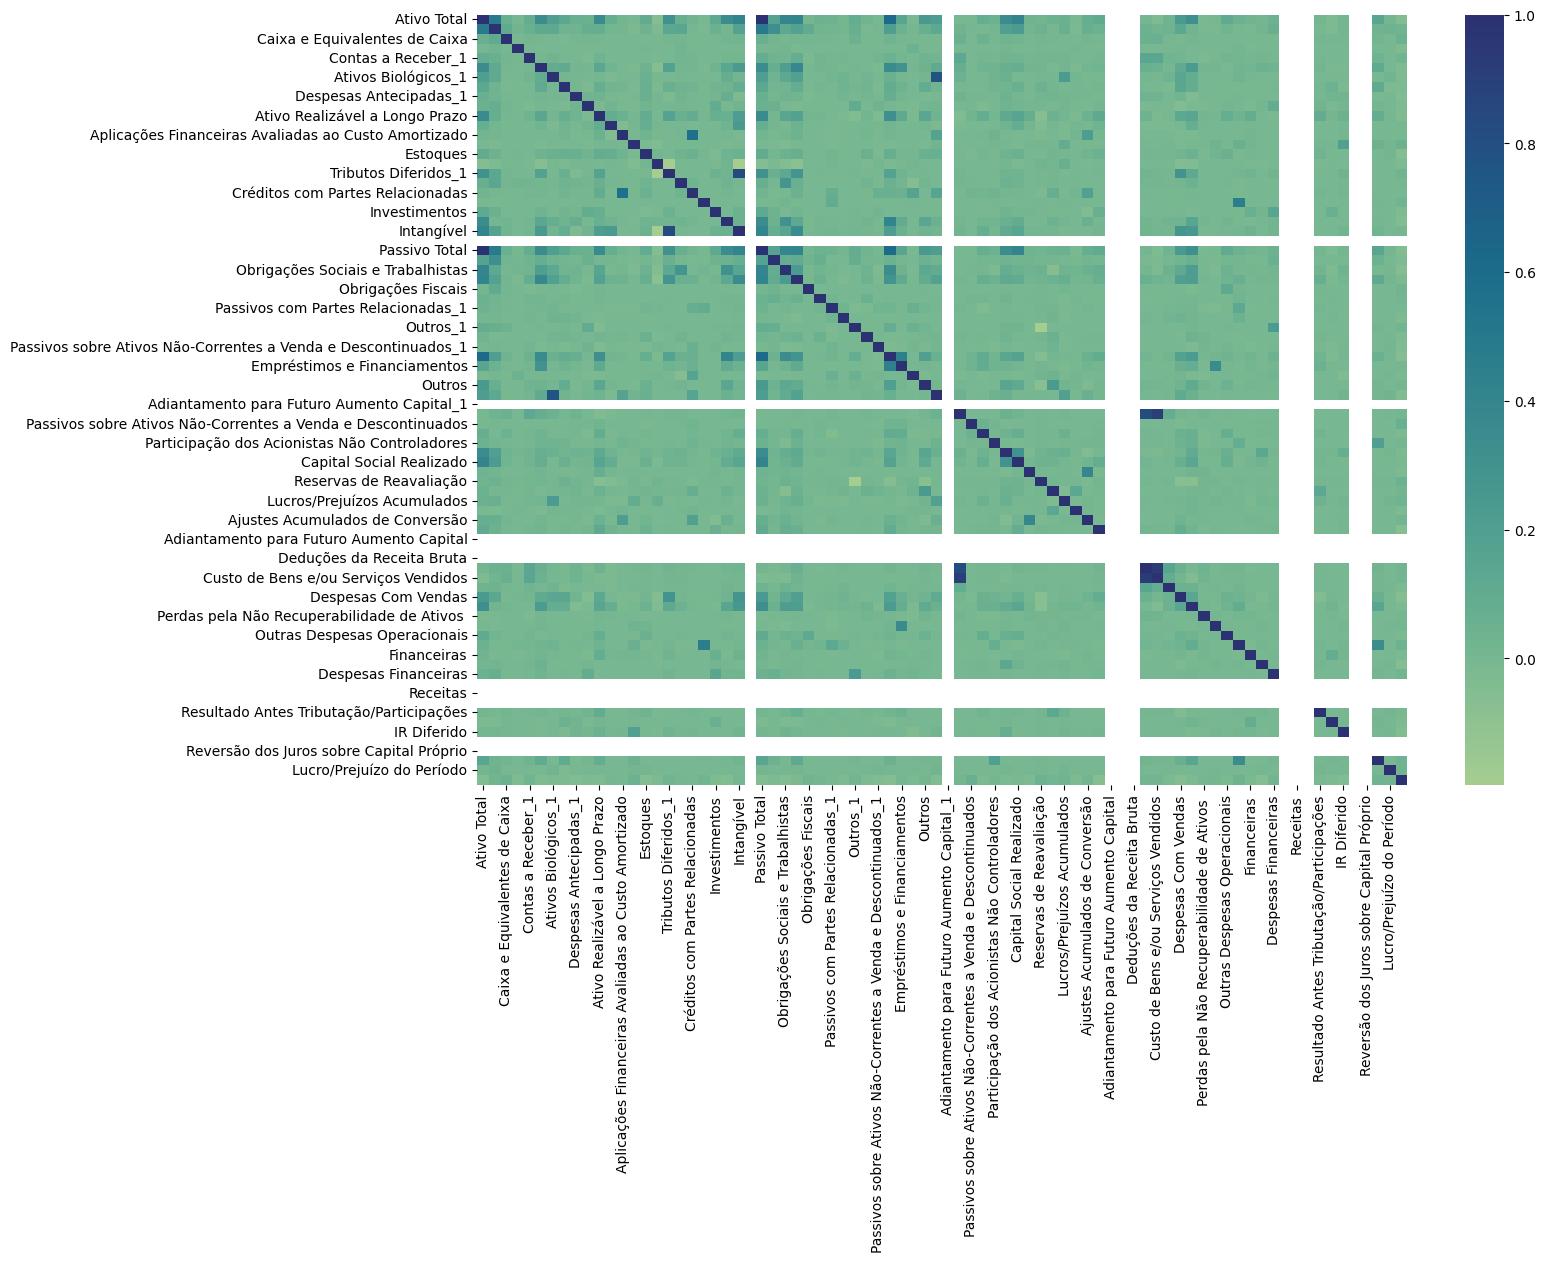

In [77]:
correlations = data_base.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(correlations, cmap="crest", ax=ax)
plt.show()

In [78]:
correlations_found = []
for col in correlations:
    for row in correlations.index:
        if row != col:
            value_cor = abs(correlations.loc[row, col])
            if value_cor > 0.8 and (col, row, value_cor) not in correlations_found:
                correlations_found.append((row, col, value_cor))
                print(f"Correlation found: {row} and {col}. Value: {value_cor}")

Correlation found: Passivo Total and Ativo Total. Value: 1.0
Correlation found: Intangível and Tributos Diferidos_1. Value: 0.8338251294392427
Correlation found: Receita Líquida de Vendas e/ou Serviços and Provisões. Value: 0.826863746636616
Correlation found: Custo de Bens e/ou Serviços Vendidos and Provisões. Value: 0.9103517679610644
Correlation found: Custo de Bens e/ou Serviços Vendidos and Receita Líquida de Vendas e/ou Serviços. Value: 0.9322979984903793


In [79]:
data_base.shape

(1336, 80)

In [80]:
remove_cor = [
    "Passivo Total",
    "Provisões",
    "Receita Líquida de Vendas e/ou Serviços",
    "Intangível",
]


print(data_base.shape)
data_base = data_base.drop(remove_cor, axis=1)
print(data_base.shape)

(1336, 80)
(1336, 76)


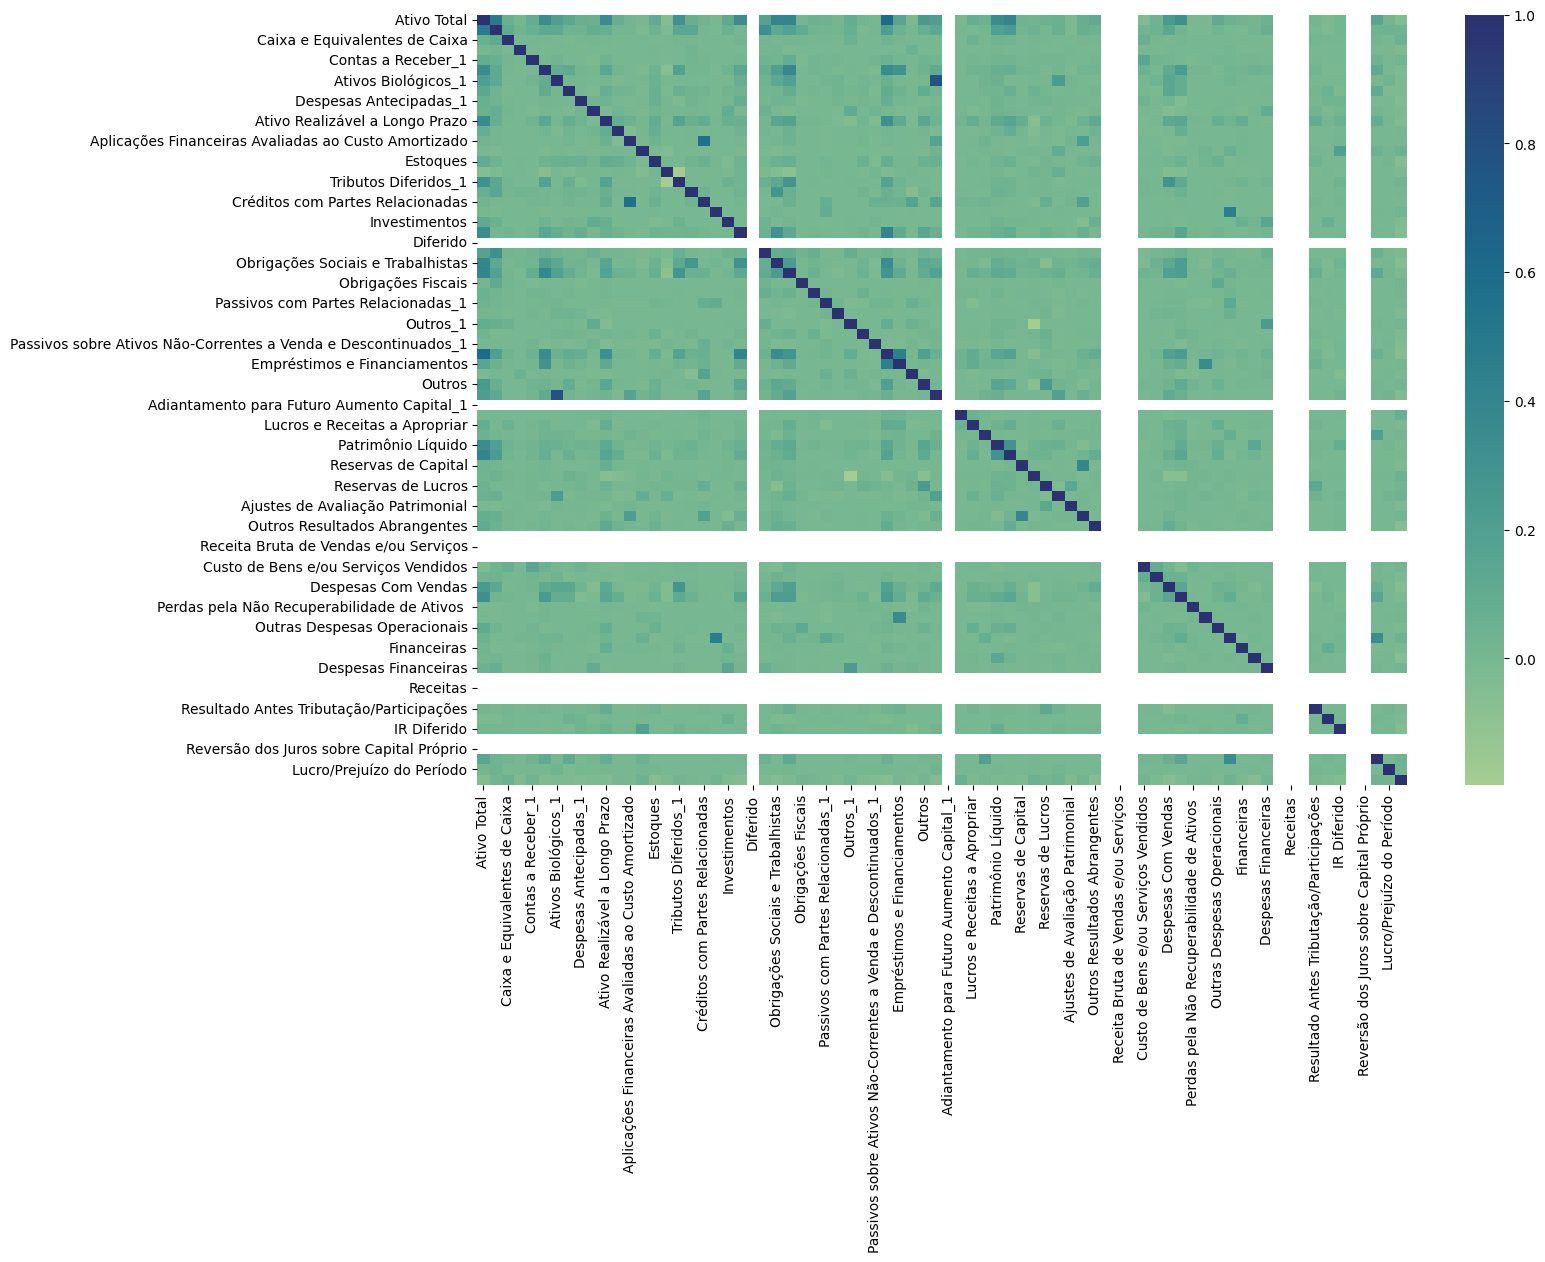

In [81]:
correlations = data_base.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(correlations, cmap="crest", ax=ax)
plt.show()

In [82]:
correlations_found = []
for col in correlations:
    for row in correlations.index:
        if row != col:
            value_cor = abs(correlations.loc[row, col])
            if value_cor > 0.8 and (col, row, value_cor) not in correlations_found:
                correlations_found.append((row, col, value_cor))
                print(f"Correlation found: {row} and {col}. Value: {value_cor}")

Feature Selection

In [84]:
from sklearn.ensemble import ExtraTreesClassifier

In [85]:
model_tree = ExtraTreesClassifier(random_state=1)
X = data_base.drop("Decision", axis=1)
y = data_base["Decision"]
model_tree.fit(X, y)

important_features = pd.DataFrame(
    model_tree.feature_importances_, X.columns
).sort_values(by=0, ascending=False)
top_10_feature = list(important_features.index)[:10]
print(top_10_feature)

['Receitas Financeiras', 'Outros Resultados Abrangentes', 'Ativo Total', 'Despesas Financeiras', 'Ativo Realizável a Longo Prazo', 'Despesas Gerais e Administrativas', 'Patrimônio Líquido', 'IR Diferido', 'Passivo Circulante', 'Despesas Com Vendas']


In [86]:
top_15_feature = list(important_features.index)[:15]
print(top_15_feature)

['Receitas Financeiras', 'Outros Resultados Abrangentes', 'Ativo Total', 'Despesas Financeiras', 'Ativo Realizável a Longo Prazo', 'Despesas Gerais e Administrativas', 'Patrimônio Líquido', 'IR Diferido', 'Passivo Circulante', 'Despesas Com Vendas', 'Obrigações Sociais e Trabalhistas', 'Lucros/Prejuízos Acumulados', 'Caixa e Equivalentes de Caixa', 'Passivo Não Circulante', 'Obrigações Fiscais']


Aplicando o StandardScaler

In [87]:
from sklearn.preprocessing import StandardScaler


def scale_adjustment(df):
    scaler = StandardScaler()
    df_aux = df.drop("Decision", axis=1)

    df_aux = pd.DataFrame(scaler.fit_transform(df_aux), df_aux.index, df_aux.columns)
    df_aux["Decision"] = df["Decision"]

    return df_aux


# new_df = scale_adjustment(data_base)
# top_10_feature.append('Decision')
# new_df = new_df[top_10_feature].reset_index(drop=True)
# display(new_df)

new_df = scale_adjustment(data_base)
top_15_feature.append("Decision")
new_df = new_df[top_15_feature].reset_index(drop=True)
display(new_df)

,Receitas Financeiras,Outros Resultados Abrangentes,Ativo Total,Despesas Financeiras,Ativo Realizável a Longo Prazo,Despesas Gerais e Administrativas,Patrimônio Líquido,IR Diferido,Passivo Circulante,Despesas Com Vendas,Obrigações Sociais e Trabalhistas,Lucros/Prejuízos Acumulados,Caixa e Equivalentes de Caixa,Passivo Não Circulante,Obrigações Fiscais,Decision
0,-0.064208,0.126486,-0.012378,-0.103001,-0.409539,0.626253,-0.143355,-0.052286,0.405738,0.230516,-0.282493,0.121445,-0.006886,-0.626542,-0.025873,0
1,-0.049446,-0.080909,-0.318358,-0.086728,-0.210052,-0.919530,-0.060087,-0.223699,-0.247876,-0.154443,-0.479130,0.173538,-0.104649,-0.307060,-0.043605,2
2,-0.054959,-0.080909,-0.140033,-0.087718,0.096813,0.128459,-0.080075,1.141335,-0.130090,-0.404457,0.367717,-0.159034,-0.096167,-0.118555,-0.052868,2
3,-0.083866,-0.080909,0.408149,-0.046460,0.467250,0.845848,-0.066681,-0.230533,0.363234,0.475775,-0.006168,-0.299179,-0.051410,-0.126858,-0.024571,2
4,-0.087479,-0.080909,-0.336697,-0.111736,-0.116244,-0.145080,-0.164295,-0.052286,-0.188369,-0.301661,0.293668,-0.062184,-0.085161,-0.071497,-0.044466,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,0.000271,-0.080909,-0.236882,-0.012035,-0.162847,-0.329591,-0.198943,-0.208571,-0.523187,0.912282,-0.925856,-0.334493,-0.145080,0.258859,-0.046936,0
1332,-0.143195,-0.080909,-0.375386,-0.135154,-0.422178,-0.240115,-0.246195,-0.196466,-0.065691,-0.445878,-0.590394,-0.372617,-0.064282,-0.248919,-0.043905,2
1333,-0.002119,-0.080909,-0.271603,-0.048625,-0.310930,0.199068,-0.231584,0.333332,-0.313042,-0.779491,0.083599,0.095710,-0.043198,-0.053058,-0.040973,0
1334,0.036632,-0.080909,-0.462812,-0.070569,0.069372,-0.008199,-0.107502,-0.056791,-0.138025,0.740725,-0.648073,0.867796,-0.126864,-0.336240,-0.027859,2


Train Test Split

In [88]:
from sklearn.model_selection import train_test_split

X = new_df.drop("Decision", axis=1)
y = new_df["Decision"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

Criando um Dummy Classifier, para termos uma baseline sobre os modelos

In [89]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

dummy = DummyClassifier(strategy="stratified", random_state=1)
dummy.fit(X_train, y_train)
prevision_dummy = dummy.predict(X_test)

Avaliação do modelo: Dummy
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.45      0.49      0.47       142
           2       0.60      0.55      0.57       192

    accuracy                           0.53       334
   macro avg       0.52      0.52      0.52       334
weighted avg       0.53      0.53      0.53       334



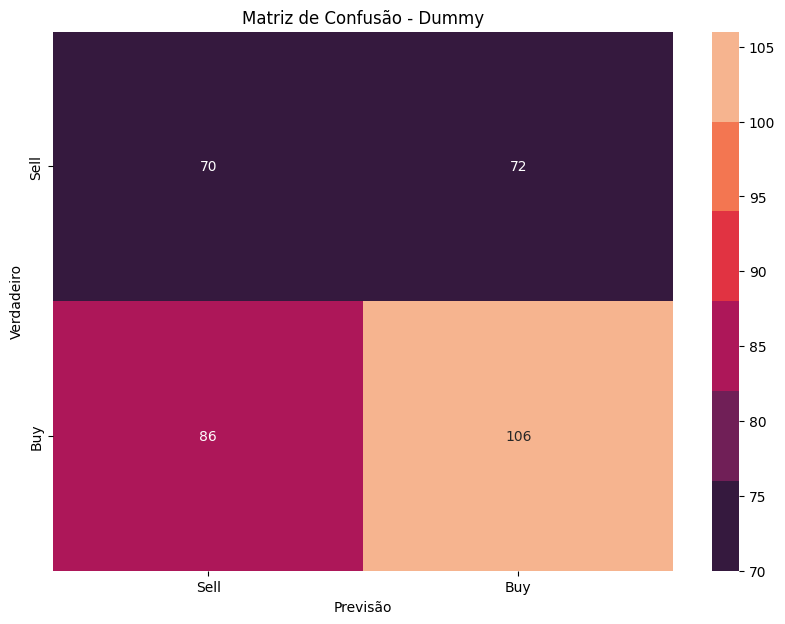

In [90]:
def evaluate_model_performance(y_test, prevision, name_model):
    try:
        # Exibir o nome do modelo
        print(f"Avaliação do modelo: {name_model}")
        
        # Gerar e exibir o relatório de classificação
        report = classification_report(y_test, prevision)
        print("Relatório de Classificação:\n", report)
        
        # Gerar a matriz de confusão
        cf_matrix = pd.DataFrame(
            confusion_matrix(y_test, prevision),
            index=["Sell", "Buy"],
            columns=["Sell", "Buy"]
        )
        
        # Plotar a matriz de confusão como um heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(cf_matrix, annot=True, cmap=sns.color_palette("rocket"), fmt="d")
        
        # Adicionar títulos ao gráfico
        plt.title(f"Matriz de Confusão - {name_model}")
        plt.xlabel("Previsão")
        plt.ylabel("Verdadeiro")
        
        
        # Exibir o gráfico
        plt.show()
        
    except Exception as e:
        print(f"Erro ao avaliar o modelo: {e}")




evaluate_model_performance(y_test, prevision_dummy, "Dummy")

#### Modelos que vamos testar
- AdaBoost
- Decision Tree
- Random Forest
- ExtraTree
- Gradient Boost
- K Nearest Neighbors (KNN)
- Logistic Regression
- Naive Bayes
- Support Vector Machine (SVM)
- Rede Neural

In [91]:
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [92]:
models = {
    "AdaBoost": AdaBoostClassifier(random_state=1),
    "Decision_Tree": DecisionTreeClassifier(random_state=1),
    "Random_Forest": RandomForestClassifier(random_state=1),
    "ExtraTree": ExtraTreesClassifier(random_state=1),
    "Gradient_Boost": GradientBoostingClassifier(random_state=1),
    "KNN": KNeighborsClassifier(),
    "Logistic_Regression": LogisticRegression(random_state=1),
    "Naive_Bayes": GaussianNB(),
    "SVM": SVC(random_state=1),
    "Rede_Neural": MLPClassifier(random_state=1, max_iter=800),
}

Avaliação do modelo: AdaBoost
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.52      0.23      0.32       142
           2       0.60      0.84      0.70       192

    accuracy                           0.58       334
   macro avg       0.56      0.54      0.51       334
weighted avg       0.56      0.58      0.54       334



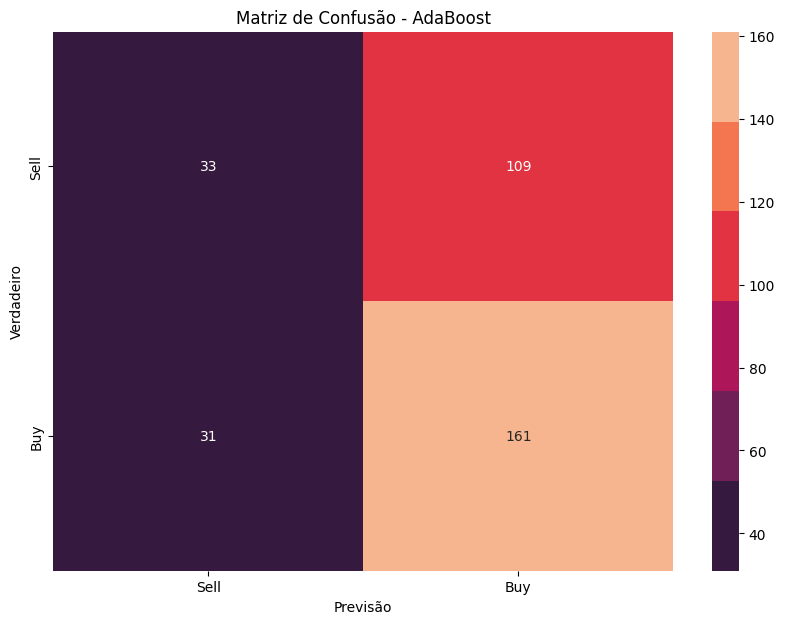

Avaliação do modelo: Decision_Tree
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51       142
           2       0.63      0.61      0.62       192

    accuracy                           0.57       334
   macro avg       0.56      0.57      0.56       334
weighted avg       0.57      0.57      0.57       334



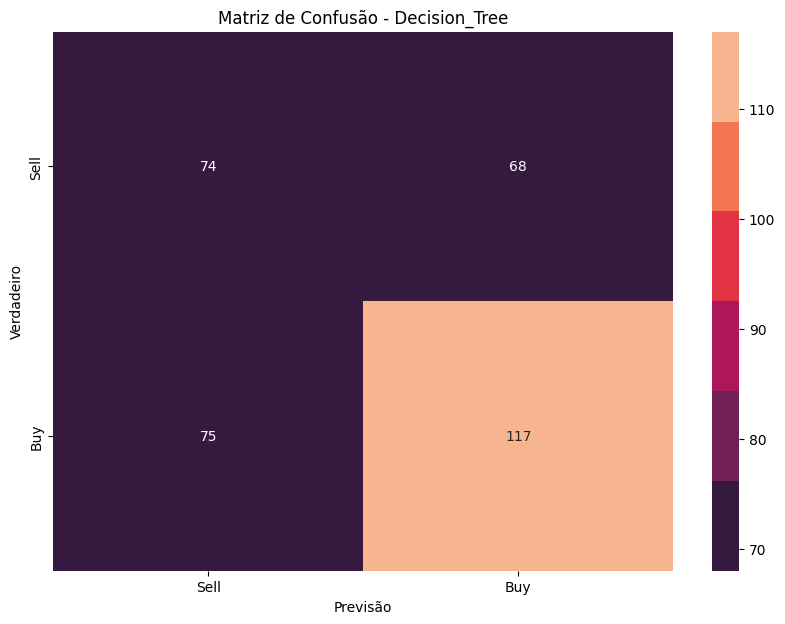

Avaliação do modelo: Random_Forest
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.54      0.42      0.47       142
           2       0.63      0.73      0.68       192

    accuracy                           0.60       334
   macro avg       0.59      0.58      0.58       334
weighted avg       0.59      0.60      0.59       334



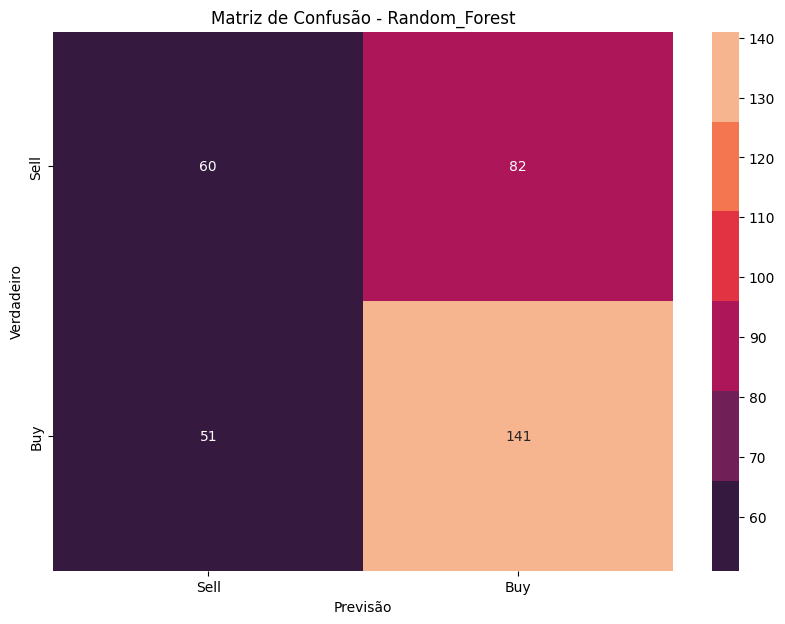

Avaliação do modelo: ExtraTree
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.49      0.40      0.44       142
           2       0.61      0.69      0.65       192

    accuracy                           0.57       334
   macro avg       0.55      0.54      0.54       334
weighted avg       0.56      0.57      0.56       334



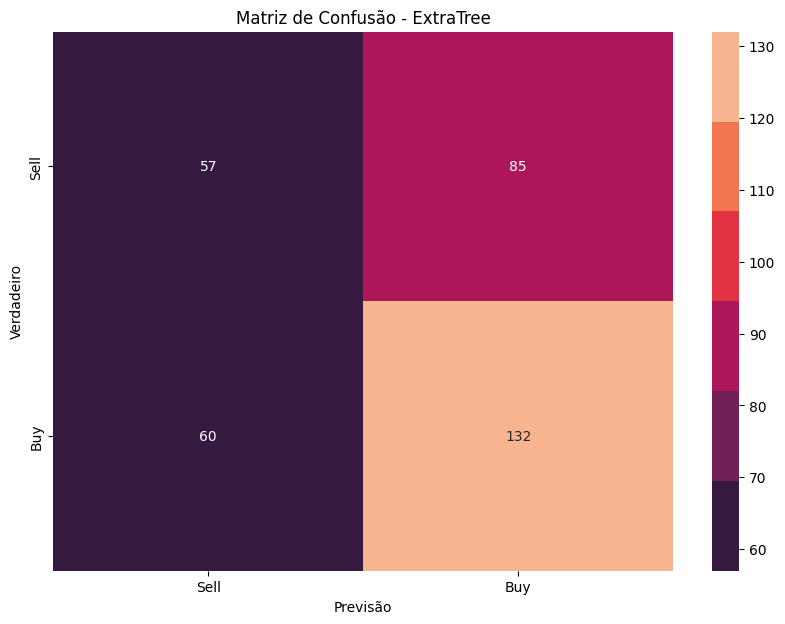

Avaliação do modelo: Gradient_Boost
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.49      0.35      0.40       142
           2       0.60      0.73      0.66       192

    accuracy                           0.57       334
   macro avg       0.54      0.54      0.53       334
weighted avg       0.55      0.57      0.55       334



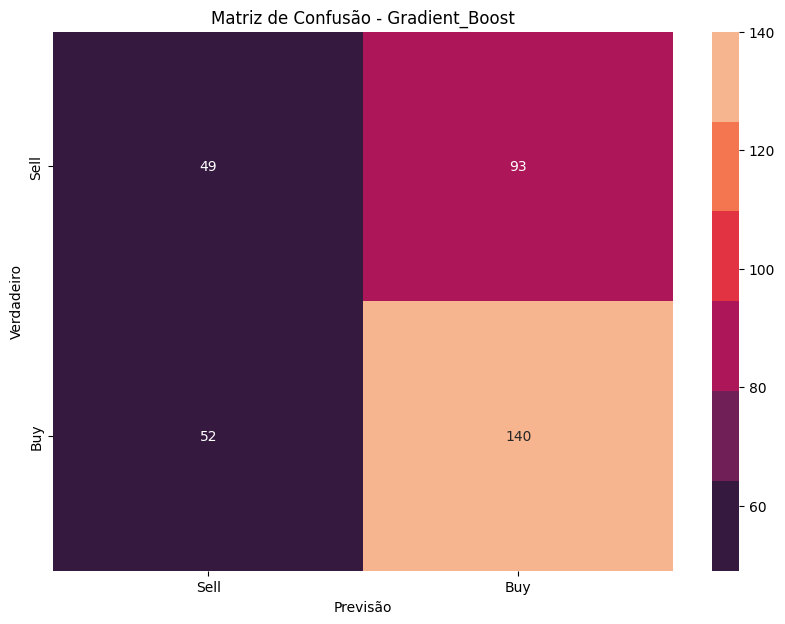

Avaliação do modelo: KNN
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.43      0.38      0.40       142
           2       0.58      0.62      0.60       192

    accuracy                           0.52       334
   macro avg       0.50      0.50      0.50       334
weighted avg       0.51      0.52      0.52       334



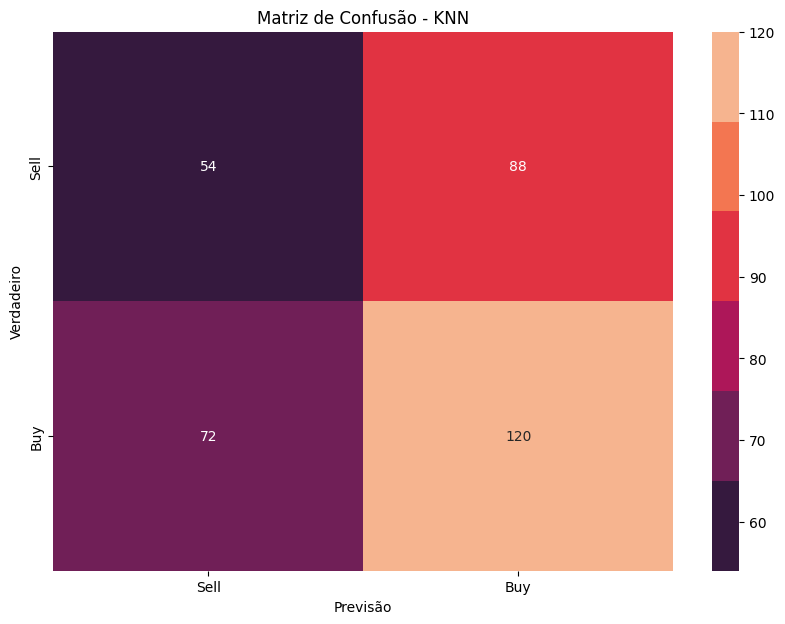

Avaliação do modelo: Logistic_Regression
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.66      0.15      0.24       142
           2       0.60      0.94      0.73       192

    accuracy                           0.60       334
   macro avg       0.63      0.55      0.49       334
weighted avg       0.62      0.60      0.52       334



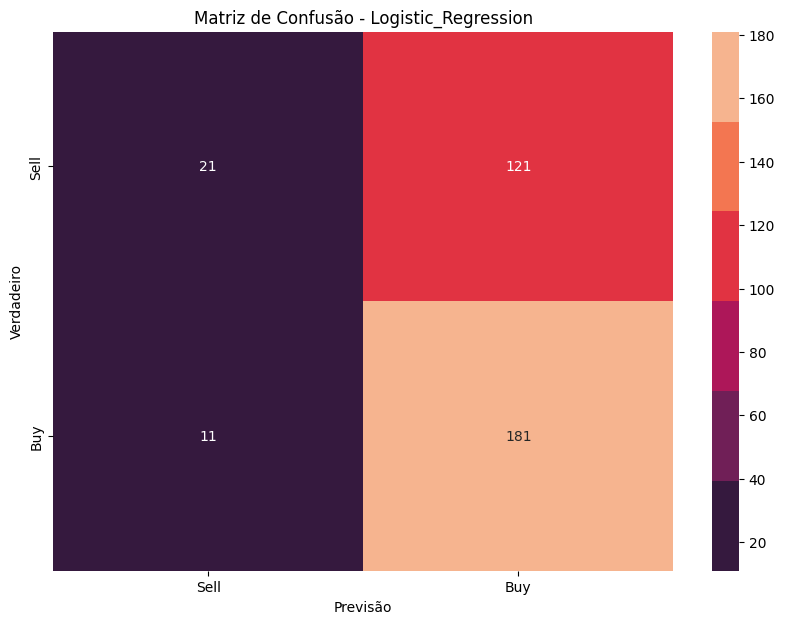

Avaliação do modelo: Naive_Bayes
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.41      0.88      0.56       142
           2       0.47      0.08      0.13       192

    accuracy                           0.42       334
   macro avg       0.44      0.48      0.35       334
weighted avg       0.45      0.42      0.32       334



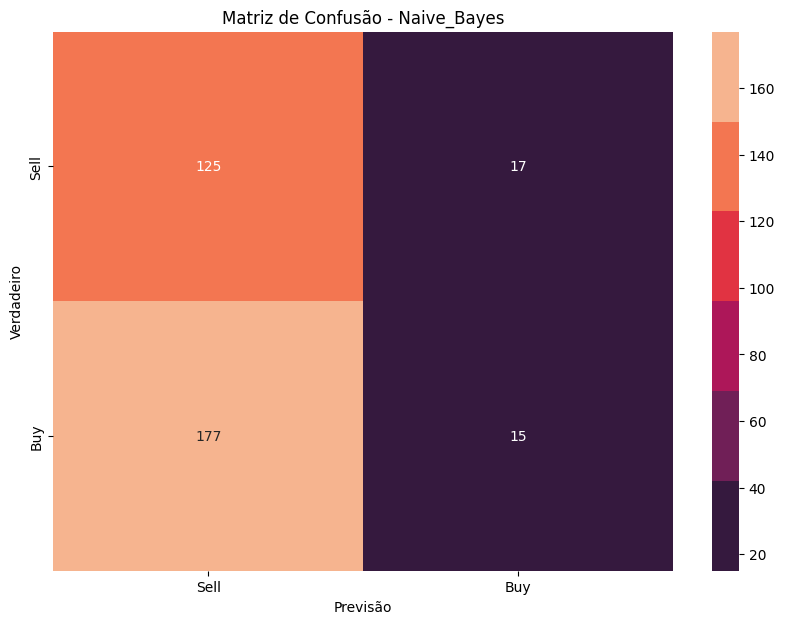

Avaliação do modelo: SVM
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.59      0.09      0.16       142
           2       0.59      0.95      0.73       192

    accuracy                           0.59       334
   macro avg       0.59      0.52      0.44       334
weighted avg       0.59      0.59      0.48       334



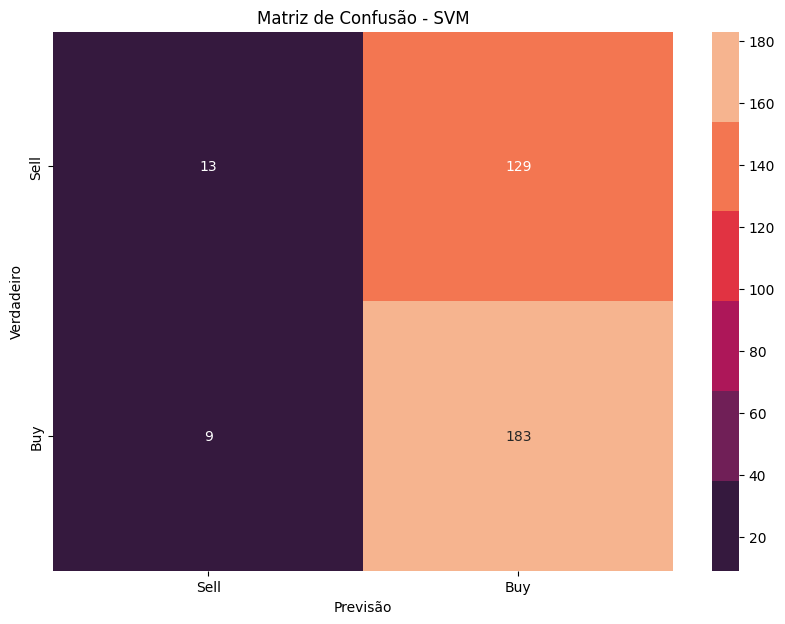

Avaliação do modelo: Rede_Neural
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.68      0.09      0.16       142
           2       0.59      0.97      0.73       192

    accuracy                           0.60       334
   macro avg       0.64      0.53      0.45       334
weighted avg       0.63      0.60      0.49       334



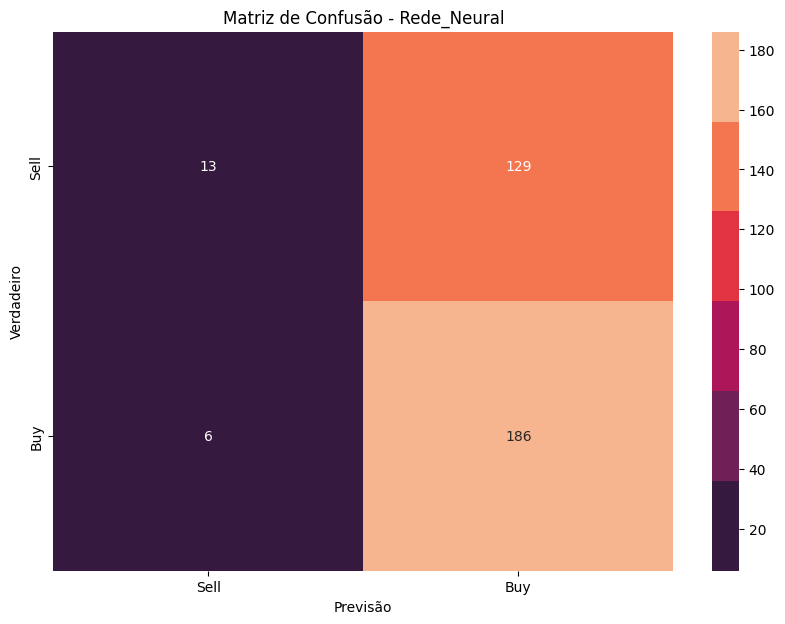

In [93]:
for model_name in models:
    model = models[model_name]
    model.fit(X_train, y_train)
    prevision = model.predict(X_test)
    evaluate_model_performance(y_test, prevision, model_name)
    models[model_name] = model

Realizando o Tuning do modelo com GridSearch

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score

# Definir modelo com balanceamento de classe
model_rf = RandomForestClassifier(class_weight="balanced", random_state=1)

# Configurar scorer personalizado
precision_personal = make_scorer(
    precision_score,
    pos_label=2,
    average="binary",
    zero_division=0,  # Lidar com ausência de rótulos
)

# Configurar validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Definir grid de parâmetros
param_grid = {
    "n_estimators": [50, 100, 150, 200],  # Número de árvores na floresta
    "criterion": ["gini", "entropy"],  # Critério para divisão
    "max_depth": [None, 5, 10, 15, 20],  # Profundidade máxima da árvore
    "min_samples_split": [2, 5, 10],  # Mínimo de amostras para dividir um nó
    "min_samples_leaf": [1, 2, 4],  # Mínimo de amostras em um nó folha
    "max_features": ["auto", "sqrt", "log2"],  # Número de features a considerar para divisão
}

# Configurar GridSearchCV
grid = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid,
    scoring=precision_personal,
    cv=cv,  # Validação cruzada estratificada
)

# Ajustar o modelo
result_grid_rf = grid.fit(X_train, y_train)

# Resultados
print("Melhores parâmetros:", result_grid_rf.best_params_)
print("Melhor pontuação:", result_grid_rf.best_score_)
print("Concluído")


Melhores parâmetros: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Melhor pontuação: 0.6176514494209094
Concluído


c:\Users\ernan\anaconda3\envs\venv-tc3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


1800 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1800 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ernan\anaconda3\envs\venv-tc3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ernan\anaconda3\envs\venv-tc3\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\ernan\anaconda3\envs\venv-tc3\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_c

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score
from sklearn.model_selection import StratifiedKFold

# Definir o modelo Random Forest com balanceamento de classe
model_rf = RandomForestClassifier(class_weight="balanced", random_state=1)

# Definir o scorer para otimizar precisão para a classe 2
precision_personal = make_scorer(precision_score, pos_label=2, average="binary", zero_division=0)

# Definir a validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Definir o grid de parâmetros
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"]
}

# Configurar o GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid,
    scoring=precision_personal,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Ajustar o modelo com os dados de treino
result_grid_rf = grid_search_rf.fit(X_train, y_train)

# Mostrar os melhores parâmetros e a melhor pontuação
print("Melhores parâmetros:", result_grid_rf.best_params_)
print("Melhor pontuação:", result_grid_rf.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Melhores parâmetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Melhor pontuação: 0.6138555656000892


c:\Users\ernan\anaconda3\envs\venv-tc3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
220 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ernan\anaconda3\envs\venv-tc3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ernan\anaconda3\envs\venv-tc3\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\ernan\anaconda3\envs\venv-tc3\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_con

Random Forest Tuning
              precision    recall  f1-score   support

           0       0.48      0.39      0.43       142
           2       0.60      0.69      0.64       192

    accuracy                           0.56       334
   macro avg       0.54      0.54      0.54       334
weighted avg       0.55      0.56      0.55       334



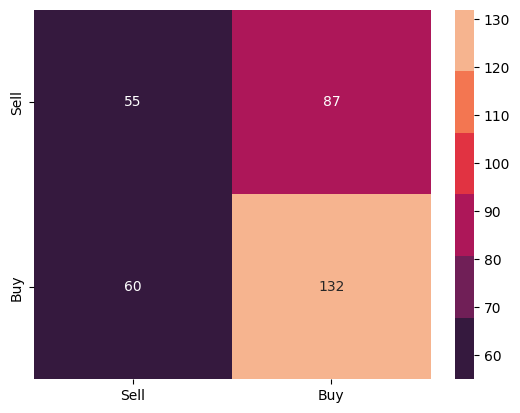

In [110]:
model_tuning = result_grid_rf.best_estimator_
prevision = model_tuning.predict(X_test)
model_evaluation(y_test, prevision, "Random Forest Tuning")

In [102]:
import pandas as pd

# Criar uma cópia de `fundamentals_copy`
ult_tri_fundamentos = fundamentals_copy.copy()

# Inicializar uma lista para armazenar DataFrames processados e uma lista para empresas
data_frames = []
lista_empresas = []

for empresa in ult_tri_fundamentos:
    # Pegar a última linha e resetar o índice
    temp_df = ult_tri_fundamentos[empresa][-1:].reset_index(drop=True)

    # Adicionar o DataFrame processado à lista
    data_frames.append(temp_df)

    # Adicionar o nome da empresa à lista
    lista_empresas.append(empresa)
    print(empresa)

# Concatenar todos os DataFrames processados em um único DataFrame
ult_tri_base_dados = pd.concat(data_frames, ignore_index=True)

# Exibir o DataFrame combinado
display(ult_tri_base_dados)
print(lista_empresas)

ABEV3
ALOS3
ALPA4
ASAI3
AURE3
AZUL4
AZZA3
B3SA3
BBSE3
BEEF3
BRAP4
BRAV3
BRFS3
CCRO3
CMIG4
CMIN3
COGN3
CPFE3
CRFB3
CSAN3
CSNA3
CVCB3
CXSE3
CYRE3
EGIE3
ELET3
EMBR3
ENEV3
ENGI11
EQTL3
EZTC3
FLRY3
GGBR4
GOAU4
HAPV3
HYPE3
IGTI11
ISAE4
ITSA4
JBSS3
KLBN11
LREN3
LWSA3
MGLU3
MRFG3
MRVE3
MULT3
NTCO3
PCAR3
PETR4
PETZ3
PRIO3
RADL3
RAIL3
RAIZ4
RDOR3
RECV3
RENT3
SBSP3
SLCE3
SMTO3
STBP3
SUZB3
TAEE11
TIMS3
TOTS3
UGPA3
VALE3
VAMO3
VBBR3
VIVA3
VIVT3
WEGE3
YDUQ3


C:\Users\ernan\AppData\Local\Temp\ipykernel_992\2757265636.py:22: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,...,Receitas,Despesas,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Participações/Contribuições Estatutárias,Reversão dos Juros sobre Capital Próprio,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Decision
0,0.104970,0.243235,0.632775,2.683133,0.248035,-0.079774,0.0,-0.271791,0.008194,0.572462,...,0.0,0.0,0.968698,0.905496,-0.805626,0.0,0.0,0.118604,0.382465,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0
2,-0.147750,0.189468,2.425721,0.000000,0.097071,-0.343519,0.0,-0.003649,-0.083087,-0.363723,...,0.0,0.0,1.000000,1.000000,-1.000000,0.0,0.0,-0.409091,1.000000,0
3,0.095157,0.178358,-0.122715,0.000000,1.331454,0.222780,0.0,0.400224,0.000000,-0.210356,...,0.0,0.0,0.788991,-1.000000,-1.000000,0.0,0.0,0.000000,0.000000,0
4,-0.045988,0.052646,-0.151694,-0.758463,0.613386,0.000000,0.0,0.253037,0.000000,0.499436,...,0.0,0.0,0.614797,0.821417,1.093097,0.0,0.0,0.000000,0.480900,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.200606,0.200903,0.340339,0.000000,-0.017505,0.170127,0.0,0.711292,-0.130769,-0.247138,...,0.0,0.0,30.666666,5.314516,-1.000000,0.0,0.0,0.000000,30.586466,0
69,0.213806,0.286107,2.809585,-0.882212,0.099946,0.240580,0.0,1.852056,-0.013661,0.000000,...,0.0,0.0,-0.216518,0.258869,1.816479,0.0,0.0,0.000000,-0.025631,0
70,0.029214,0.159425,0.257899,-1.000000,0.080621,0.578545,0.0,0.220107,0.077118,-0.104783,...,0.0,0.0,0.270779,-0.520862,1.000000,0.0,0.0,-1.000000,0.485433,0
71,0.247908,0.173696,0.112883,0.134061,0.148914,0.219941,0.0,0.208865,0.000000,0.308680,...,0.0,0.0,0.209727,0.255997,-0.342286,-0.0,0.0,0.977433,0.153667,0


['ABEV3', 'ALOS3', 'ALPA4', 'ASAI3', 'AURE3', 'AZUL4', 'AZZA3', 'B3SA3', 'BBSE3', 'BEEF3', 'BRAP4', 'BRAV3', 'BRFS3', 'CCRO3', 'CMIG4', 'CMIN3', 'COGN3', 'CPFE3', 'CRFB3', 'CSAN3', 'CSNA3', 'CVCB3', 'CXSE3', 'CYRE3', 'EGIE3', 'ELET3', 'EMBR3', 'ENEV3', 'ENGI11', 'EQTL3', 'EZTC3', 'FLRY3', 'GGBR4', 'GOAU4', 'HAPV3', 'HYPE3', 'IGTI11', 'ISAE4', 'ITSA4', 'JBSS3', 'KLBN11', 'LREN3', 'LWSA3', 'MGLU3', 'MRFG3', 'MRVE3', 'MULT3', 'NTCO3', 'PCAR3', 'PETR4', 'PETZ3', 'PRIO3', 'RADL3', 'RAIL3', 'RAIZ4', 'RDOR3', 'RECV3', 'RENT3', 'SBSP3', 'SLCE3', 'SMTO3', 'STBP3', 'SUZB3', 'TAEE11', 'TIMS3', 'TOTS3', 'UGPA3', 'VALE3', 'VAMO3', 'VBBR3', 'VIVA3', 'VIVT3', 'WEGE3', 'YDUQ3']


In [103]:
ult_tri_base_dados = ult_tri_base_dados.reset_index(drop=True)
ult_tri_base_dados = ult_tri_base_dados[top_15_feature]
ult_tri_base_dados = scale_adjustment(ult_tri_base_dados)
ult_tri_base_dados = ult_tri_base_dados.drop("Decision", axis=1)
display(ult_tri_base_dados)

,Receitas Financeiras,Outros Resultados Abrangentes,Ativo Total,Despesas Financeiras,Ativo Realizável a Longo Prazo,Despesas Gerais e Administrativas,Patrimônio Líquido,IR Diferido,Passivo Circulante,Despesas Com Vendas,Obrigações Sociais e Trabalhistas,Lucros/Prejuízos Acumulados,Caixa e Equivalentes de Caixa,Passivo Não Circulante,Obrigações Fiscais
0,-0.477307,0.072513,-0.045275,-0.292008,-0.225301,0.048847,0.113143,-0.192704,-0.200996,-0.366530,0.218826,0.095247,0.101562,-0.404827,-0.152890
1,-0.049843,0.072513,-0.400655,-0.172317,-0.288989,-0.402658,-0.357368,-0.170658,-0.262338,-0.413789,-0.436574,-0.540719,-0.337100,-0.394340,-0.171622
2,2.295185,-1.502149,-0.900867,-0.213654,-0.622035,-0.565266,-1.138480,-0.198023,-0.167057,-0.705988,0.559228,0.369372,1.344494,-0.227263,-0.124135
3,0.362918,1.122287,-0.078496,-0.095002,-0.488657,0.786958,0.283388,-0.198023,-0.083277,-0.058172,0.425376,-0.540719,-0.422171,-0.320494,-0.111561
4,-1.054756,0.072513,-0.556350,-0.352896,-0.625751,0.143525,-0.812928,-0.140745,-0.047719,-0.413789,-0.276622,-0.093861,-0.442260,-0.395495,-0.124671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1.599935,0.072513,0.278504,-0.319218,0.542215,1.096700,1.460532,-0.198023,0.103813,-0.532916,0.492417,-0.540719,-0.101165,-0.553803,0.375019
69,1.005748,-1.502149,0.323191,0.047872,-0.335060,-0.016669,0.455955,-0.120950,0.040431,-0.459736,-0.020447,0.717497,1.610603,-0.339671,-0.165782
70,-0.728800,1.031573,-0.301750,-0.259201,-0.329971,-0.088922,-0.340536,-0.143293,-0.192723,-0.330794,0.057752,-0.127408,-0.158316,-0.277314,-0.166235
71,0.236454,1.182885,0.438645,-0.119904,0.740539,0.824563,0.506749,-0.180025,0.065319,0.333971,0.607486,0.121691,-0.258846,-0.413430,-0.114699


In [111]:
previsoes_ult_tri = model_tuning.predict(ult_tri_base_dados)
for index, value in enumerate(previsoes_ult_tri):
    if value == 2:
        print(f"{lista_empresas[index]}, Buy")
    elif value == 0:
        print(f"{lista_empresas[index]}, Sell")

ABEV3, Buy
ALOS3, Buy
ALPA4, Buy
ASAI3, Sell
AURE3, Sell
AZUL4, Sell
AZZA3, Sell
B3SA3, Sell
BBSE3, Buy
BEEF3, Buy
BRAP4, Sell
BRAV3, Buy
BRFS3, Sell
CCRO3, Sell
CMIG4, Buy
CMIN3, Sell
COGN3, Sell
CPFE3, Sell
CRFB3, Sell
CSAN3, Sell
CSNA3, Buy
CVCB3, Sell
CXSE3, Buy
CYRE3, Buy
EGIE3, Sell
ELET3, Buy
EMBR3, Sell
ENEV3, Buy
ENGI11, Sell
EQTL3, Sell
EZTC3, Sell
FLRY3, Buy
GGBR4, Buy
GOAU4, Buy
HAPV3, Sell
HYPE3, Buy
IGTI11, Sell
ISAE4, Sell
ITSA4, Buy
JBSS3, Sell
KLBN11, Sell
LREN3, Sell
LWSA3, Sell
MGLU3, Sell
MRFG3, Sell
MRVE3, Sell
MULT3, Sell
NTCO3, Sell
PCAR3, Sell
PETR4, Buy
PETZ3, Buy
PRIO3, Sell
RADL3, Sell
RAIL3, Buy
RAIZ4, Buy
RDOR3, Sell
RECV3, Sell
RENT3, Sell
SBSP3, Buy
SLCE3, Buy
SMTO3, Buy
STBP3, Sell
SUZB3, Sell
TAEE11, Sell
TIMS3, Sell
TOTS3, Sell
UGPA3, Sell
VALE3, Sell
VAMO3, Buy
VBBR3, Buy
VIVA3, Sell
VIVT3, Sell
WEGE3, Sell
